## Support Vector Machines


Given a binary classification problem, the goal of **any classifier** is to find the “best” line that has the best chance of classifying unseen points correctly, given the data we have at hand.

**How you define this notion of “best chance” gives you how different models get built.**

With SVMs, the definition of "best model" relies on finding the **maximally separating hyperplane between the classes**. There are 2 kinds of SVM models, linear SVMs, and kernel-based (nonlinear SVMs).

![svm example](../images/svm_example.png)

Let's begin by comparing the decision boundaries for the LR and SVM model when data is separable:

In [1]:
import numpy as np
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hinge_loss
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## SVMs when the data is perfectly separable

In [2]:
# let's create 40 separable points
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
y = [0] * 20 + [1] * 20

# fit the LR model
clf_lr = LogisticRegression(C=1e8)
clf_lr.fit(X, y)

# fit the SVM model
clf_svm = svm.SVC(kernel='linear',C=1e8)
clf_svm.fit(X, y)

SVC(C=100000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Let's now generate the grids for our 2 models, to visualize and compare their two decision boundaries

In [3]:
x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
x2_min, x2_max = X[:, 1].min(), X[:, 1].max()

xx, yy = np.mgrid[x1_min:x1_max:.01, x2_min:x2_max:.01] #generate the grid, output 2 arrays
lr_grid = np.c_[xx.ravel(), yy.ravel()] #concatenate along the 2nd axis

#use these x and y values as inputs to generate predicted probabilities across the entire space
lr_probs = clf_lr.predict_proba(lr_grid)[:, 1].reshape(xx.shape)

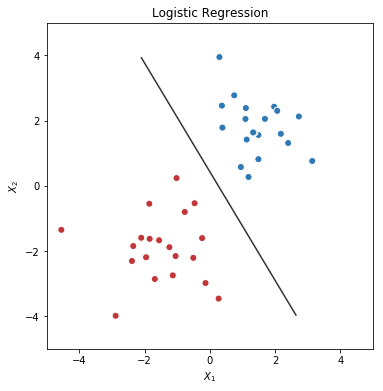

In [4]:
#generate a blank figure
f, ax = plt.subplots(figsize=(8, 6))

#add contours based on our grid and probabilities, this time we eliminate all values other than 0.5
ax.contour(xx, yy, lr_probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")
ax.set_title("Logistic Regression");

We can also pull the decision boundary out of the linear SVM directly:

In [4]:
# get the separating hyperplane
w = clf_svm.coef_[0]
a = -w[0] / w[1]
xx_svm = np.linspace(-5, 5)
yy_svm = a * xx_svm - (clf_svm.intercept_[0]) / w[1]

In [5]:
# get the parallels to the separating hyperplane that pass through the support vectors
b = clf_svm.support_vectors_[0]
yy_down = a * xx_svm + (b[1] - a * b[0])
b = clf_svm.support_vectors_[-1]
yy_up = a * xx_svm + (b[1] - a * b[0])

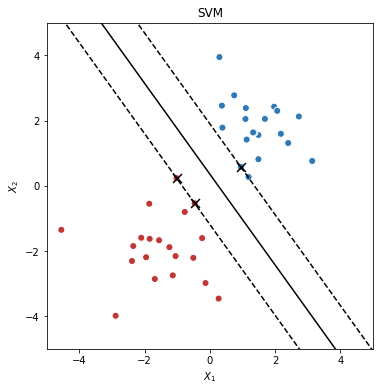

In [7]:
#generate a blank figure
f, ax = plt.subplots(figsize=(8, 6))

#plot the points
ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

#plot the support vectors
ax.scatter(clf_svm.support_vectors_[:, 0], clf_svm.support_vectors_[:, 1],
            s=80, facecolors='black', marker='x')

# plot the decision boundary
ax.plot(xx_svm, yy_svm, 'k-')

#plot the lines that pass through the support vectors
ax.plot(xx_svm, yy_down, 'k--')
ax.plot(xx_svm, yy_up, 'k--')

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")
ax.set_title("SVM");

Let's look at them both on the same figure:

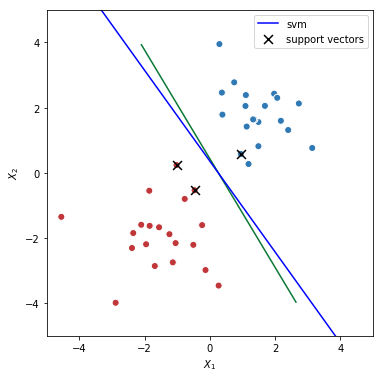

In [6]:
#generate a blank figure
f, ax = plt.subplots(figsize=(8, 6))

#plot the points
ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

#plot the support vectors
ax.scatter(clf_svm.support_vectors_[:, 0], clf_svm.support_vectors_[:, 1],
            s=80, facecolors='black', marker='x',label="support vectors")

# plot the svm decision boundary
ax.plot(xx_svm, yy_svm, 'b-',label="svm")

#add contours based on our grid and probabilities, this time we eliminate all values other than 0.5
ax.contour(xx, yy, lr_probs, levels=[.5], cmap="Greens", vmin=0, vmax=.6)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$");
ax.legend();

Why do the 2 linear models generate different decision boundaries?

Take a look at this figure, which shows you the penalty associated with getting an example wrong as a function of how close you are to the "correct" answer:
![losses](../images/loss_functions_lr_svm.png)

* In the SVM case (hinge loss), the loss function has the same slope, no matter how far "off" you are.
* In the LR case (logistic loss), the loss function's slope rapidly increases as you get a given example more and more wrong (in math speak, it diverges).

What this means is that the LR model will be much more sensitive to outliers.

Furthermore, notice that the logistic loss does not go to zero even if the point is classified sufficiently confidently. This may occasionally lead to a minor degradation in accuracy.

## SVMs when data is not separable

In [7]:
import pandas as pd
# Let's use our earlier dataset
kidney_columns = ["age","bp","sg","al","su","rbc","pc","pcc","ba",
                  "bgr","bu","sc","sod","pot","hemo","pcv","wc","rc",
                  "htn","dm","cad","appet","pe","ane","class"]
kidney_data = pd.read_csv("../data/chronic_kidney_disease.csv", names=kidney_columns,na_values="?")
kidney_columns = kidney_columns[:5]+kidney_columns[9:18]+kidney_columns[5:9]+kidney_columns[18:]
kidney_data = kidney_data[kidney_columns]
kidney_data["class"] = (kidney_data["class"]=="ckd").astype(int)
kidney_data.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,normal,notpresent,notpresent,yes,yes,no,good,no,no,1
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,1
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,normal,notpresent,notpresent,no,yes,no,poor,no,yes,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,abnormal,present,notpresent,yes,no,no,poor,yes,yes,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,1


In [8]:
#fill the numeric data
median_per_column = kidney_data[kidney_columns[:14]].apply(lambda x: x.median(),axis=0)
numeric_median_filled = kidney_data[kidney_columns[:14]].fillna(median_per_column,axis=0)

In [9]:
#Zscore
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #create a scaler object
scaler.fit(numeric_median_filled) #fit the scaler
numeric_scaled = scaler.transform(numeric_median_filled) #transform the data with it
numeric_scaled = pd.DataFrame(numeric_scaled,columns=kidney_columns[:14])
numeric_scaled.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
0,-0.210031,0.254214,0.421486,0.076249,-0.380269,-0.320122,-0.419451,-0.319668,0.040104,-0.062903,1.053226,0.603224,-0.197314,0.550044
1,-2.627234,-1.972476,0.421486,2.363728,-0.380269,-0.320122,-0.784315,-0.390819,0.040104,-0.062903,-0.457965,-0.132789,-0.909782,0.074073
2,0.615355,0.254214,-1.421074,0.838742,2.507853,3.697618,-0.074858,-0.212942,0.040104,-0.062903,-1.084556,-0.991470,-0.316059,0.074073
3,-0.210031,-0.488016,-2.342354,2.363728,-0.380269,-0.373337,-0.014047,0.142813,-2.896333,-0.737181,-0.494823,-0.868801,-0.632711,-0.996862
4,-0.033163,0.254214,-1.421074,0.838742,-0.380269,-0.519679,-0.622154,-0.284093,0.040104,-0.062903,-0.347390,-0.500795,-0.395222,-0.163913


In [10]:
#our 2-feature model, this time with an SVM
feature_cols = ['bgr',"pcv"]
X_norm_2dim = numeric_scaled[feature_cols]
y_norm = kidney_data["class"]

In [11]:
# create a mesh to visualize decision boundaries
margin = .5
h=0.01
x_min, x_max = X_norm_2dim.iloc[:, 0].min() - margin, X_norm_2dim.iloc[:, 0].max() + margin
y_min, y_max = X_norm_2dim.iloc[:, 1].min() - margin, X_norm_2dim.iloc[:, 1].max() + margin
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [12]:
#function to help with plotting
def plot_clf_and_title(clf, title):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max],[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    yhat = clf.predict(X_norm_2dim)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    # Plot also the training points
    plt.scatter(X_norm_2dim.iloc[:, 0], X_norm_2dim.iloc[:, 1], c=y_norm, cmap=plt.cm.coolwarm,label="")
    # Also plot support vectors:
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='black', marker='*', s=30,
                label="support vectors")
    plt.xlabel('BGR')
    plt.ylabel('PCV')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.legend()
    plt.show()
    print('{}: {:0.2f}% error'.format(title, (1-np.mean(y_norm==yhat))*100))

### Linear SVM boundary

In [16]:
svm_lin_2dim = svm.SVC(kernel="linear")
svm_lin_2dim.fit(X_norm_2dim, y_norm)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

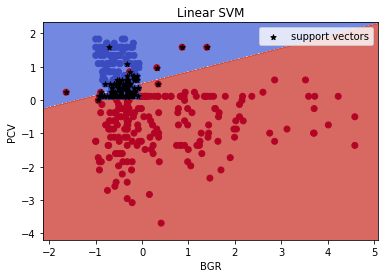

Linear SVM: 11.25% error


In [19]:
plot_clf_and_title(svm_lin_2dim,
                   "Linear SVM")

## Nonlinear SVMs and the Kernel Trick

Support vector machines do not have to generate linear decision boundaries, especially in cases where the separating boundary should be nonlinear.

In order to motivate how a nonlinear SVM works, we can consider a standard "trick" in linear regression, when considering non-linear situations.

In particular a set of p features $x1,...,xp$ can be transformed, say, into a set of $2p$ features $x1,x^2_1,...,xp,x^2_p$.

![kernel trick](../images/kernel_trick_idea.png)


**This allows us to apply a linear technique to a set of non-linear features.**

While the decision boundary is linear in the new $2p$-dimensional feature space it is non-linear in the original $p$-dimensional space.

This is clearly not restricted to quadratic polynomials. Higher dimensional polynomials, interaction terms and other functional forms, could all be considered. 

**However, the drawback is that this explicit creation of higher-order features dramatically increases the dimension of the feature space to the point that some algorithms can become untractable (this is known as the curse of dimensionality)**.

The major advantage of SVMs is that they allow a non-linear enlargening of the feature space, while still retaining a significant computational efficiency, using a process known as the "kernel trick".

So what are SVMs? In essence they are an extension of linear SVCs that results from enlargening the feature space through the use of functions known as [kernels](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick).

While calculating the solution to the SVC optimisation problem, the algorithm only needs to make use of [inner products](https://en.wikipedia.org/wiki/Inner_product_space) between the observations and not the observations themselves.

While I won't go into the details, it is possible to show that a linear support vector classifier for a particular observation can be represented as a linear combination of inner products. 

**In fact, you ONLY need to calculate the inner products for the subset of training observations that represent the support vectors.**

This turns out to have a major advantage for computational efficiency. You only need to compute anything on those examples that are in opposite categories but very close to each other in the original space (since that is where the boundary between the classes would lie).

This now motivates the extension to SVMs. If you take the original inner product calculation and replace it with a more general inner product "kernel" function, we can modify the SVC representation to use non-linear kernel functions and thus modify how we calculate "similarity" between two observations.

Lets examine each kind of "kernel" in practice, as well as the parameters that can be used within them to get a sense for how they would generate decision boundaries:

In [20]:
# Polynomial SVC
deg=2
poly_svc = svm.SVC(kernel="poly",degree=deg).fit(X_norm_2dim, y_norm)

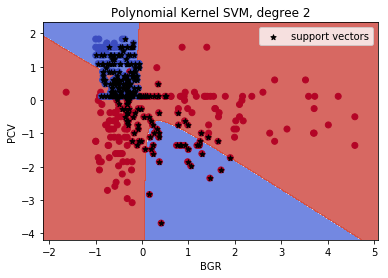

Polynomial Kernel SVM, degree 2: 25.75% error


In [21]:
plot_clf_and_title(poly_svc,"Polynomial Kernel SVM, degree {}".format(deg))

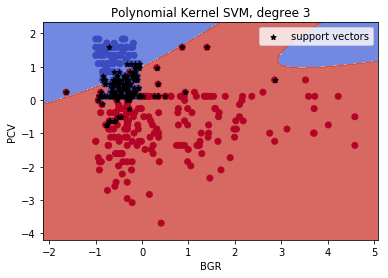

Polynomial Kernel SVM, degree 3: 19.00% error


In [22]:
deg=3
poly_svc = svm.SVC(kernel="poly",degree=deg).fit(X_norm_2dim, y_norm)
plot_clf_and_title(poly_svc,"Polynomial Kernel SVM, degree {}".format(deg))

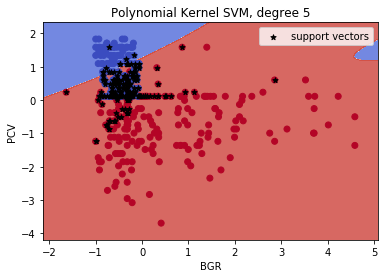

Polynomial Kernel SVM, degree 5: 21.75% error


In [23]:
deg=5
poly_svc = svm.SVC(kernel="poly",degree=deg).fit(X_norm_2dim, y_norm)
plot_clf_and_title(poly_svc,"Polynomial Kernel SVM, degree {}".format(deg))

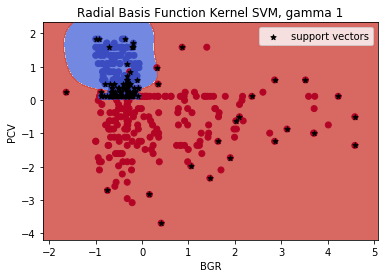

Radial Basis Function Kernel SVM, gamma 1: 10.00% error


In [24]:
#Radial Basis Function Kernel
gam = 1
rbf_svc = svm.SVC(kernel="rbf",gamma=gam).fit(X_norm_2dim, y_norm)
plot_clf_and_title(rbf_svc,"Radial Basis Function Kernel SVM, gamma {}".format(gam))

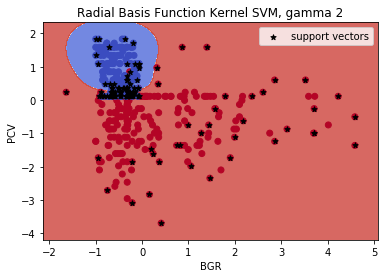

Radial Basis Function Kernel SVM, gamma 2: 9.75% error


In [25]:
gam = 2
rbf_svc = svm.SVC(kernel="rbf",gamma=gam).fit(X_norm_2dim, y_norm)
plot_clf_and_title(rbf_svc,"Radial Basis Function Kernel SVM, gamma {}".format(gam))

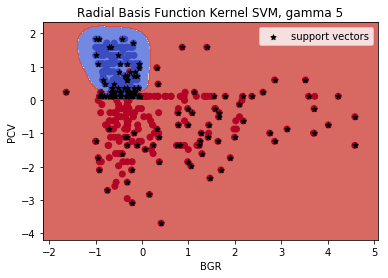

Radial Basis Function Kernel SVM, gamma 5: 6.25% error


In [26]:
gam = 5
rbf_svc = svm.SVC(kernel="rbf",gamma=gam).fit(X_norm_2dim, y_norm)
plot_clf_and_title(rbf_svc,"Radial Basis Function Kernel SVM, gamma {}".format(gam))

We will get into the weeds with regularization and what it is later today, but I want to quickly show you how to change the number of support vectors your algorithm will use as a function of the C parameter (a regularization parameter), which affects how rigid you want your margin to be, in cases where perfect separability is not possible.

$C$ collectively controls how much the individual datapoints can violate the margin. C=0 forces as little violation of the margin is possible, in which case (for separable classes) we have the maximum margin situation we saw in the perfectly separable case.

For C>0 it means that no more than C observations can violate the margin. As C increases, the margin will widen:

In [27]:
def svm_best_plotter(clf, X, y):
    x_label = X.columns.tolist()[0]
    y_label = X.columns.tolist()[1]
    X = X.values
    y = y.values
    clf.fit(X, y)
    yhat = clf.predict(X)
    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(1,figsize=(8, 8))
    plt.clf()

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,zorder=10,label="")
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=5, c='black', marker='x', zorder=12)

    x_min = X.min(axis=0)[0]
    x_max = X.max(axis=0)[0]
    y_min = X.min(axis=0)[1]
    y_max = X.max(axis=0)[1]

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(1,figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.coolwarm)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show() 
    print('{}% error with {} support vectors'.format((1-np.mean(y==yhat))*100, clf.support_vectors_.shape[0]))

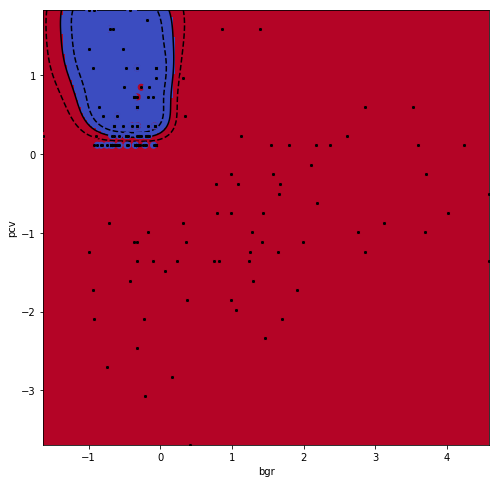

6.25% error with 163 support vectors


In [28]:
clf_lowc = svm.SVC(kernel='rbf', gamma=5, C=1)
svm_best_plotter(clf_lowc, X_norm_2dim, y_norm)

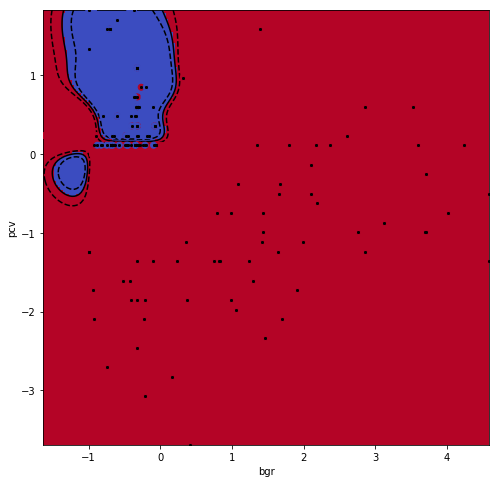

6.25% error with 135 support vectors


In [29]:
clf_highc = svm.SVC(kernel='rbf', gamma=5, C=100)
svm_best_plotter(clf_highc, X_norm_2dim, y_norm)

## SVMs, nonlinear classifiers, and interpretability

In general, SVMs work by trying to classify the "most difficult to classify" examples. This means that interpreting a given SVM requires looking at the specific samples from your dataset that the algorithm has identified as the support vectors, and then investigating the weights on features within those support vectors.

Granted, this is done "automagically" with neuroscience-related packages, but this is something to keep in mind. 

Furthermore, in general, nonlinear models are rarely used for understanding the "information" encoded in some region/sensor/voxel/etc.

Specifically, as mentioned by Pereira et al.:

>it is not clear that they always provide a significant advantage in practical performance relative to linear classifiers...In our opinion this is more a reflection of the fact that the number of examples available is so small than of the absence of complicated relationships between features. The second reason is that the relationship between features and the prediction can become harder to interpret when these classifiers are used. This doesn’t mean that they cannot be used fruitfully when the number of features is smaller, in particular when doing information-based mapping.